In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

In [3]:
dat = pd.read_csv("./college_earnings_for_modeling.csv")

In [4]:
print(dat.columns)
print(dat.shape) # plenty of data to work with
dat.head()

Index(['School Name', 'State', 'School Ownership',
       'Full-time Faculty Rate (%)', 'Faculty Average Salary',
       'Student Enrollment Size', 'Attendance Cost',
       '150% Completion Rate at 4 Yr (%)', 'Admission Rate (%)',
       'RetentionRate_4yr', 'Female_Majority', 'SAT Average (Overall)',
       'SAT 75th Percentile Math', 'SAT 75th Percentile Reading',
       'SAT 75th Percentile Writing',
       'Percent of Students Earning >$25K (6 Yrs after Entry)',
       'Percent of Students Earning >$25K (10 Yrs after Entry)',
       'LowIncRatio_10yr', 'HighIncRatio_10yr', 'LowIncRatio_6yr',
       'HighIncRatio_6yr', 'Mean Earnings (6 Yrs after Entry)',
       'Mean Earnings (10 Yrs after Entry)'],
      dtype='object')
(1989, 23)


,School Name,State,School Ownership,Full-time Faculty Rate (%),Faculty Average Salary,Student Enrollment Size,Attendance Cost,150% Completion Rate at 4 Yr (%),Admission Rate (%),RetentionRate_4yr,...,SAT 75th Percentile Reading,SAT 75th Percentile Writing,Percent of Students Earning >$25K (6 Yrs after Entry),Percent of Students Earning >$25K (10 Yrs after Entry),LowIncRatio_10yr,HighIncRatio_10yr,LowIncRatio_6yr,HighIncRatio_6yr,Mean Earnings (6 Yrs after Entry),Mean Earnings (10 Yrs after Entry)
0,Alabama A & M University,AL,Public,99.60,91188.0,5090.0,23445.0,28.66,89.65,54.03,...,520.0,457.0,45.3,5990.0,0.090177,0.032613,0.179371,0.028291,28400.0,35500.0
1,University of Alabama at Birmingham,AL,Public,76.19,136560.0,13549.0,25542.0,61.17,80.60,86.40,...,668.0,NaN,66.9,7470.0,0.096243,0.047900,0.108421,0.055355,39400.0,48400.0
2,University of Alabama in Huntsville,AL,Public,67.02,116364.0,7825.0,24861.0,57.14,77.11,81.80,...,700.0,NaN,68.5,7790.0,0.087157,0.048307,0.087540,0.045240,40300.0,52000.0
3,Alabama State University,AL,Public,67.97,86328.0,3603.0,21892.0,31.77,98.88,62.02,...,531.0,NaN,39.3,5280.0,0.421593,0.041910,0.330003,0.034416,24400.0,30600.0
4,The University of Alabama,AL,Public,77.07,124188.0,30610.0,30016.0,72.14,80.39,87.23,...,660.0,600.0,69.5,7860.0,0.046521,0.066122,0.057269,0.077328,42400.0,51600.0


In [5]:
# examine issues further
dat = dat[dat["Student Enrollment Size"]!=0] # 3 universities with no reported enrollment ---also missing many other vars
missing_values = dat.isnull().sum()
# print(missing_values.sort_values(ascending=False))
missing_values_in_rows = dat.isnull().sum(axis=1)
print(missing_values_in_rows.sort_values(ascending=False))
# important to consider: what is good threshold of missing values to constitue throwing out obs?
# could also try EM algorithm + MI for imputing these data

# drop obs with missing values in response column(s)
dat = dat[dat["Mean Earnings (6 Yrs after Entry)"].isnull()==False]



1761    18
1794    18
1774    17
1939    17
1918    17
        ..
1081     0
1083     0
1085     0
1089     0
994      0
Length: 1986, dtype: int64


In [6]:
# look for missing values/other potential issues
dat.describe()

,Full-time Faculty Rate (%),Faculty Average Salary,Student Enrollment Size,Attendance Cost,150% Completion Rate at 4 Yr (%),Admission Rate (%),RetentionRate_4yr,SAT Average (Overall),SAT 75th Percentile Math,SAT 75th Percentile Reading,SAT 75th Percentile Writing,Percent of Students Earning >$25K (6 Yrs after Entry),Percent of Students Earning >$25K (10 Yrs after Entry),LowIncRatio_10yr,HighIncRatio_10yr,LowIncRatio_6yr,HighIncRatio_6yr,Mean Earnings (6 Yrs after Entry),Mean Earnings (10 Yrs after Entry)
count,1700.000000,1720.000000,1735.000000,1652.000000,1665.000000,1476.000000,1657.000000,1060.000000,1017.000000,1017.000000,667.000000,1717.000000,1693.000000,1690.000000,1589.000000,1701.000000,1607.000000,1736.000000,1707.000000
mean,65.420712,96844.172093,5001.518732,38032.791162,55.156354,70.078686,74.219813,1142.497170,610.472960,613.925270,572.245877,64.880955,7391.128175,2.763992,0.642358,3.742308,0.495008,39203.571429,50261.862917
std,26.933711,31461.827918,8442.298665,17114.296557,19.858825,20.193190,14.072419,130.185605,73.280119,60.746718,80.238175,14.047024,1174.523732,37.883640,7.252906,47.429555,4.914861,11389.718248,16219.323778
min,0.000000,11916.000000,13.000000,5663.000000,0.000000,5.010000,0.000000,842.000000,405.000000,415.000000,360.000000,8.100000,900.000000,0.001126,0.000568,0.004929,0.002765,13300.000000,18000.000000
25%,45.882500,77220.000000,900.000000,23588.500000,42.920000,59.880000,67.590000,1053.000000,560.000000,570.000000,520.000000,58.000000,6880.000000,0.065933,0.057860,0.073143,0.062799,32700.000000,40850.000000
50%,68.275000,91572.000000,1894.000000,34450.000000,55.330000,74.025000,76.160000,1117.000000,600.000000,610.000000,560.000000,66.700000,7650.000000,0.121958,0.096552,0.142178,0.101329,37600.000000,47900.000000
75%,89.300000,112833.000000,5244.000000,50152.750000,68.530000,84.525000,83.170000,1207.000000,650.000000,650.000000,610.000000,73.400000,8140.000000,0.208883,0.149088,0.254232,0.155258,43100.000000,55550.000000
max,100.000000,253716.000000,109233.000000,81531.000000,100.000000,100.000000,100.000000,1566.000000,800.000000,780.000000,800.000000,97.200000,9570.000000,892.514019,158.458333,1111.083333,137.083333,104500.000000,171800.000000


In [7]:
# define features and target
features = ["School Ownership", 'Full-time Faculty Rate (%)', 'Faculty Average Salary', 'Student Enrollment Size','Attendance Cost',
            '150% Completion Rate at 4 Yr (%)', 'Admission Rate (%)', 'RetentionRate_4yr',  "Female_Majority",'SAT Average (Overall)']
X = dat.loc[:,features]
X.index = dat['School Name']
target = dat['Mean Earnings (6 Yrs after Entry)']
target2 = dat['Mean Earnings (10 Yrs after Entry)']

Xtrain, Xtest0, ytrain, ytest0 = train_test_split(X,target,random_state=4015,test_size=0.3)
Xvalid,Xtest,yvalid,ytest = train_test_split(Xtest0,ytest0, random_state=4015,test_size=0.3)

In [8]:
X.dtypes

School Ownership                     object
Full-time Faculty Rate (%)          float64
Faculty Average Salary              float64
Student Enrollment Size             float64
Attendance Cost                     float64
150% Completion Rate at 4 Yr (%)    float64
Admission Rate (%)                  float64
RetentionRate_4yr                   float64
Female_Majority                        bool
SAT Average (Overall)               float64
dtype: object

In [9]:
numeric_features = X.select_dtypes(exclude=['object']).columns
categorical_features = ['School Ownership']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    # ("poly2", PolynomialFeatures(degree=2)),
    # ("scaler", StandardScaler()) # not going to scale for now, to keep as much interpretability as possible
    # also, important to be careful with scaling 0, 1 vars (and probably don't want to scale them)
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

mypipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(oob_score=True))
])

# fit pipe to the training data
# mypipe.fit(Xtrain,ytrain)

In [71]:
# run preprocessor 
X_filled= preprocessor.fit_transform(X)
Xtrain_filled = preprocessor.fit_transform(Xtrain)
Xtest_filled= preprocessor.fit_transform(Xtest)

# get feature names from one hot encoder
ohenc_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out()
# ohenc_names2 = preprocessor.named_transformers_['cat']['encoder'].feature_names_in_
# num_names = preprocessor.named_transformers_['num']['scaler'].get_feature_names_out()
# print(num_names)
feature_names = list(Xtest.columns)[1:]+list(ohenc_names)
print(Xtest.columns)
print(len(ohenc_names))
print(feature_names)
print(len(feature_names))
print(Xtrain_filled.shape)
display(Xtrain.head())
print(Xtrain.shape)

# get indexes from train and test
Xtrain.index

display(pd.DataFrame(Xtrain_filled))
# redefine dataframes with appropriate column names
X_filled = pd.DataFrame(X_filled, columns=feature_names,index = X.index)
Xtrain_filled = pd.DataFrame(Xtrain_filled, columns=feature_names,index = Xtrain.index)
Xtest_filled = pd.DataFrame(Xtest_filled, columns=feature_names,index = Xtest.index)
Xtrain_filled.head()


Index(['School Ownership', 'Full-time Faculty Rate (%)',
       'Faculty Average Salary', 'Student Enrollment Size', 'Attendance Cost',
       '150% Completion Rate at 4 Yr (%)', 'Admission Rate (%)',
       'RetentionRate_4yr', 'Female_Majority', 'SAT Average (Overall)'],
      dtype='object')
3
['Full-time Faculty Rate (%)', 'Faculty Average Salary', 'Student Enrollment Size', 'Attendance Cost', '150% Completion Rate at 4 Yr (%)', 'Admission Rate (%)', 'RetentionRate_4yr', 'Female_Majority', 'SAT Average (Overall)', 'x0_Private ForProfit', 'x0_Private NonProfit', 'x0_Public']
12
(1215, 12)


,School Ownership,Full-time Faculty Rate (%),Faculty Average Salary,Student Enrollment Size,Attendance Cost,150% Completion Rate at 4 Yr (%),Admission Rate (%),RetentionRate_4yr,Female_Majority,SAT Average (Overall)
School Name,,,,,,,,,,
Saginaw Valley State University,Public,50.28,101148.0,6953.0,22353.0,47.88,89.46,77.37,True,1086.0
Centre College,Private NonProfit,93.20,99564.0,1333.0,56645.0,83.16,72.08,89.30,True,1325.0
SUNY Empire State College,Public,22.53,89832.0,8221.0,19726.0,27.03,NaN,64.91,True,NaN
Boise Bible College,Private NonProfit,90.00,54900.0,94.0,24258.0,38.64,90.38,66.67,False,988.0
West Coast University-Dallas,Private ForProfit,25.56,88980.0,1182.0,27991.0,100.00,NaN,0.00,True,NaN


(1215, 10)


,0,1,2,3,4,5,6,7,8,9,10,11
0,50.28,101148.0,6953.0,22353.0,47.88,89.460000,77.37,1.0,1086.000000,0.0,0.0,1.0
1,93.20,99564.0,1333.0,56645.0,83.16,72.080000,89.30,1.0,1325.000000,0.0,1.0,0.0
2,22.53,89832.0,8221.0,19726.0,27.03,70.226986,64.91,1.0,1142.511968,0.0,0.0,1.0
3,90.00,54900.0,94.0,24258.0,38.64,90.380000,66.67,0.0,988.000000,0.0,1.0,0.0
4,25.56,88980.0,1182.0,27991.0,100.00,70.226986,0.00,1.0,1142.511968,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1210,100.00,93840.0,842.0,49420.0,67.55,97.550000,84.47,1.0,1209.000000,0.0,1.0,0.0
1211,33.03,82896.0,548.0,28397.0,13.04,70.226986,50.00,1.0,1142.511968,1.0,0.0,0.0
1212,53.38,84516.0,2225.0,50923.0,68.63,73.310000,83.52,1.0,1205.000000,0.0,1.0,0.0
1213,98.21,85008.0,1389.0,58485.0,74.95,80.180000,80.83,1.0,1143.000000,0.0,1.0,0.0


,Full-time Faculty Rate (%),Faculty Average Salary,Student Enrollment Size,Attendance Cost,150% Completion Rate at 4 Yr (%),Admission Rate (%),RetentionRate_4yr,Female_Majority,SAT Average (Overall),x0_Private ForProfit,x0_Private NonProfit,x0_Public
School Name,,,,,,,,,,,,
Saginaw Valley State University,50.28,101148.0,6953.0,22353.0,47.88,89.460000,77.37,1.0,1086.000000,0.0,0.0,1.0
Centre College,93.20,99564.0,1333.0,56645.0,83.16,72.080000,89.30,1.0,1325.000000,0.0,1.0,0.0
SUNY Empire State College,22.53,89832.0,8221.0,19726.0,27.03,70.226986,64.91,1.0,1142.511968,0.0,0.0,1.0
Boise Bible College,90.00,54900.0,94.0,24258.0,38.64,90.380000,66.67,0.0,988.000000,0.0,1.0,0.0
West Coast University-Dallas,25.56,88980.0,1182.0,27991.0,100.00,70.226986,0.00,1.0,1142.511968,1.0,0.0,0.0


In [11]:
# fit model
rf = RandomForestRegressor(oob_score=True)
rf.fit(Xtrain_filled,ytrain)

RandomForestRegressor(oob_score=True)

In [12]:
rf.oob_score_ # ~57% oob rsq

0.5617869762973083

In [77]:
# begin shap
import shap
from shap import TreeExplainer
explainer = TreeExplainer(rf)
# shap_values_train = explainer.shap_values(Xtrain)
shap_values_test = explainer(Xtrain_filled) # test this out on smaller subset to start
shap_values = explainer(X_filled) # now get shap values for all 


In [90]:
# find test case universities
print(np.argwhere(Xtrain_filled.index == 'Pacific Lutheran University'))
idx_of_interest1 = np.argwhere(X_filled.index == 'Pacific Lutheran University')[0][0]
print(idx_of_interest1)
idx_of_interest2 = np.argwhere(X_filled.index == 'Brigham Young University')[0][0]
print(idx_of_interest2)

[[51]]
1487
1417


In [79]:
# examine shap values
shap_values_test

.values =
array([[  173.14971281,   665.05220327,   313.46378539, ...,
          -33.67203653,   213.2007721 ,   573.81877616],
       [ -470.6858945 ,  -229.16158301,  -868.81612023, ...,
          -96.23526047,   -79.79415008,   -27.94895464],
       [ 1429.36337263,  1947.01431567,   805.75700684, ...,
           11.81183982,   296.4923462 ,   667.23114821],
       ...,
       [  500.05369071, -1172.84655469,  1352.8665745 , ...,
          -45.06463326,   -33.59092705,   -25.17705929],
       [  121.66264879, -1079.64590429,  1358.73284124, ...,
          -39.55553186,   -35.97246513,   -52.80325175],
       [ -340.25156055,  -324.6945691 ,   187.89373769, ...,
          -41.02695908,   249.58498962,   603.53759476]])

.base_values =
array([39349.93744856, 39349.93744856, 39349.93744856, ...,
       39349.93744856, 39349.93744856, 39349.93744856])

.data =
array([[5.02800e+01, 1.01148e+05, 6.95300e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [9.32000e+01, 9.95640

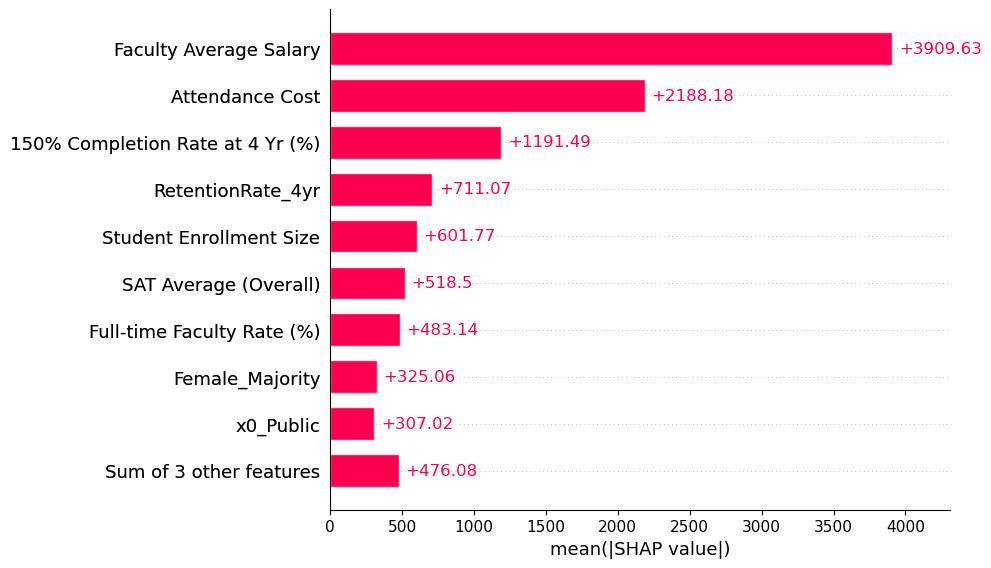

In [80]:
# global summary
shap.plots.bar(shap_values)

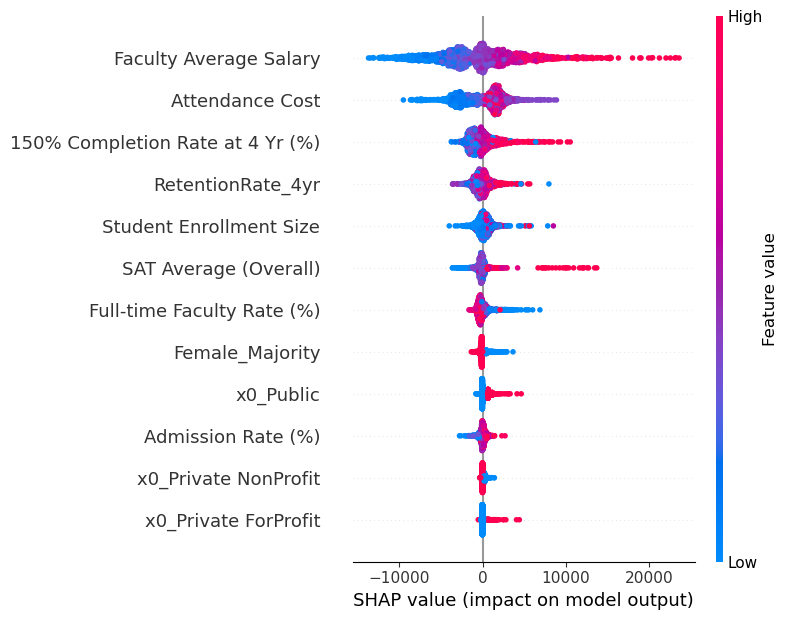

In [82]:
shap.summary_plot(shap_values)

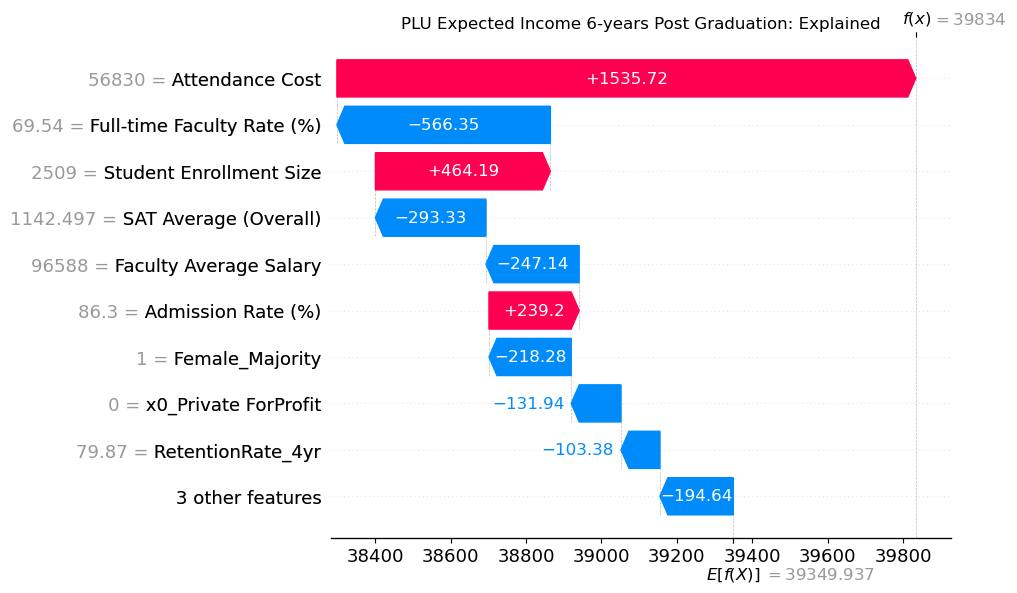

In [91]:
# PLU
shap.plots.waterfall(shap_values[idx_of_interest1],show=False)
plt.title('PLU Expected Income 6-years Post Graduation: Explained', y = 1)
plt.show()

In [ ]:
# BYU
shap.plots.waterfall(shap_values[idx_of_interest2],show=False)
plt.title('BYU Expected Income 6-years Post Graduation: Explained', y = 1)
plt.show()

In [87]:
# shap.plots.force(shap_values_test[147]) # need Javascript library to use forceplot

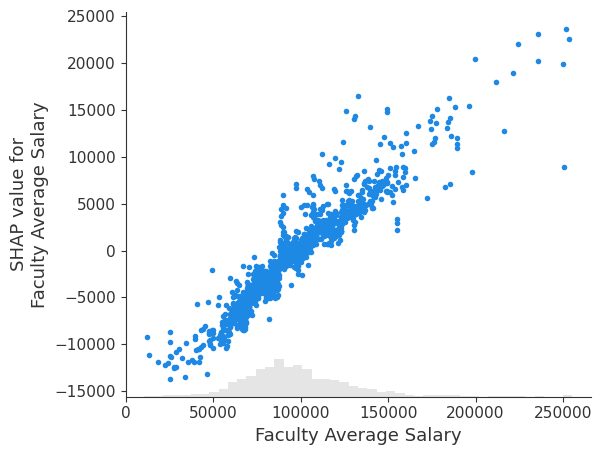

In [38]:
# examine single feature
shap.plots.scatter(shap_values_test[:, 'Faculty Average Salary'])

Faculty Average Salary appears to be the most influential on Expected Income; however, are there any **potential interations** with other variables?

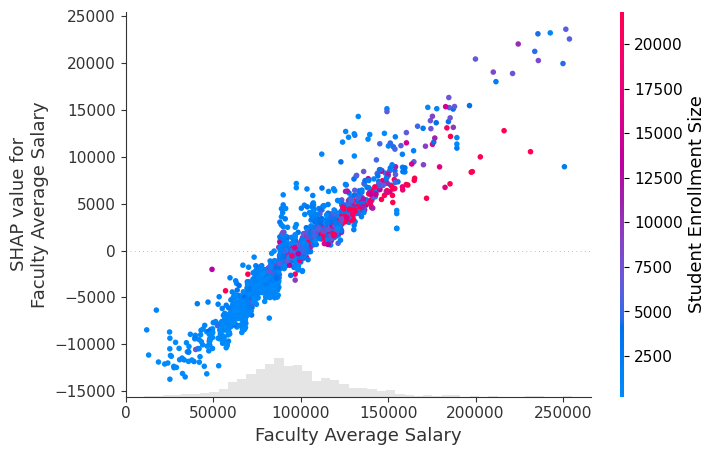

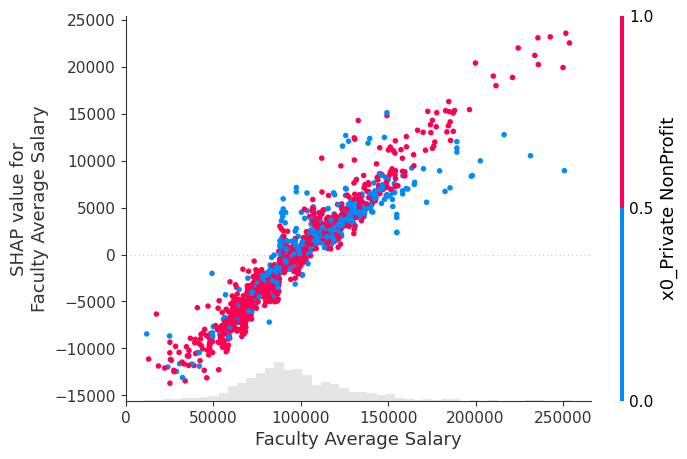

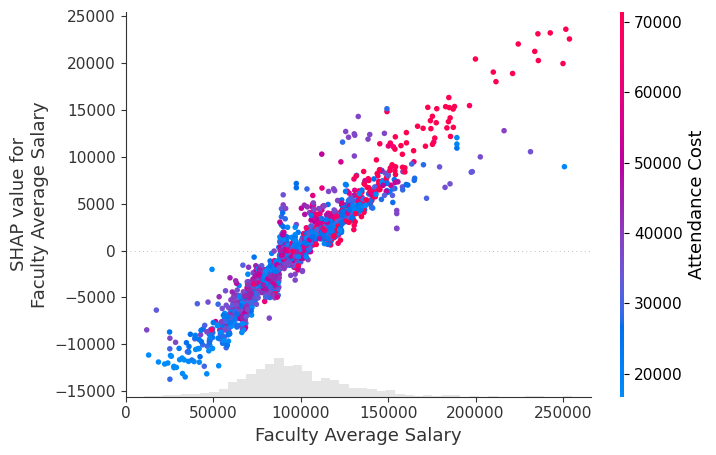

In [86]:

inds_fs = shap.utils.potential_interactions(shap_values[:, 'Faculty Average Salary'], shap_values)
# make plots colored by each of the top possible interacting features
top_num = 3
for i in range(top_num):
    shap.plots.scatter(shap_values[:, "Faculty Average Salary"], color=shap_values[:, inds[i]])